共同生育期: ['2022_Booting' '2022_Flowering' '2023_Booting' '2023_Flowering'
 '2023_Heading']


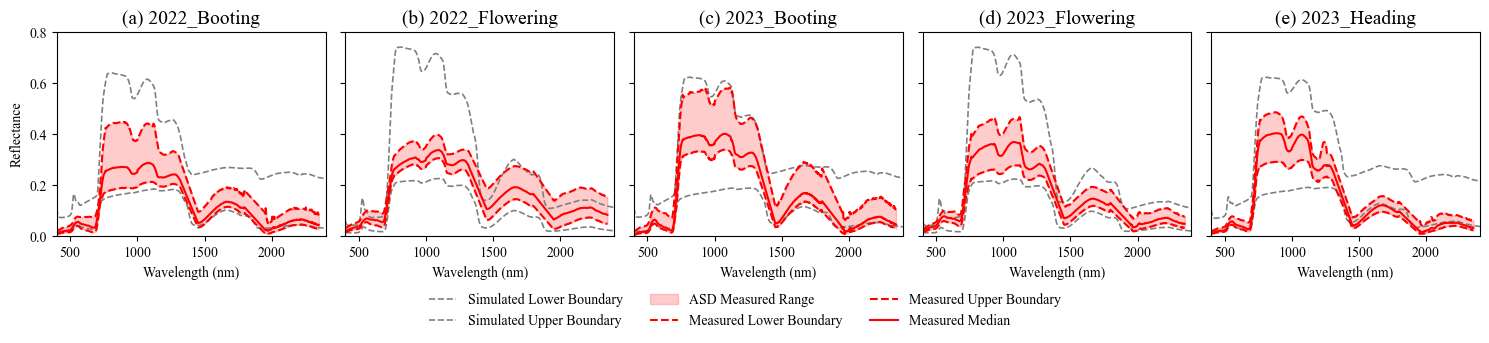

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'

# --- 加载数据 ---
wavelengths = np.arange(400, 2501)
sim_hs_cp = np.load('D:/JIE/CODE/GITHUB/project/data/lut/Y_hs.npy')
stages = np.load('../../data/lut/stage_labels.npy')
real = np.load('../../data/real/Y_asd_hs.npy')
wavelength_real = np.load('../../data/real/wavelength.npy')
stages_real = np.load('../../data/real/stages.npy')
# --- 统一生育期标签 ---
sim_stages_unique = np.unique(stages)
real_stages_unique = np.unique(stages_real)

# 只保留两者都有的生育期
common_stages = np.intersect1d(sim_stages_unique, real_stages_unique)
print(f"共同生育期: {common_stages}")

# --- 按共同生育期筛选数据 ---
# 筛选模拟数据
sim_mask = np.isin(stages, common_stages)
sim_hs_filtered = sim_hs_cp[sim_mask]
stages_filtered = stages[sim_mask]

# --- 统计模拟数据分位数（按生育期分组）---
sim_percentiles = {}
for stage in common_stages:
    stage_mask = stages_filtered == stage
    stage_data = sim_hs_filtered[stage_mask]
    sim_percentiles[stage] = {
        'p05': np.nanpercentile(stage_data, 2, axis=0),
        'p95': np.nanpercentile(stage_data, 98, axis=0)
    }

# --- 创建实测数据列表 ---
meas_list = []
for stage in common_stages:
    stage_mask = stages_real == stage
    stage_data = real[stage_mask]
    meas_list.append((stage_data, stage))

# --- 绘图 ---
fig, axs = plt.subplots(1, len(common_stages), figsize=(15, 3), sharey=True)

# 用于图例的标记
legend_added = {
    'sim_lower': False,
    'sim_upper': False,
    'meas_range': False,
    'meas_lower': False,
    'meas_upper': False,
    'meas_median': False
}

for i, (ax, stage) in enumerate(zip(axs, common_stages)):
    # 获取当前生育期的模拟数据分位数
    sim_p05 = sim_percentiles[stage]['p05']
    sim_p95 = sim_percentiles[stage]['p95']

    # 模拟数据边界线
    ax.plot(wavelengths, sim_p05, color='gray', linestyle='--', linewidth=1.2,
            label='Simulated Lower Boundary' if not legend_added['sim_lower'] else "")
    if not legend_added['sim_lower']:
        legend_added['sim_lower'] = True

    ax.plot(wavelengths, sim_p95, color='gray', linestyle='--', linewidth=1.2,
            label='Simulated Upper Boundary' if not legend_added['sim_upper'] else "")
    if not legend_added['sim_upper']:
        legend_added['sim_upper'] = True

    # --- 实测数据处理 ---
    stage_found = False
    for spec, s_stage in meas_list:
        if s_stage == stage:
            stage_found = True
            # 实测数据使用其自己的波长
            meas_q1 = np.nanpercentile(spec, 5, axis=0)
            meas_q3 = np.nanpercentile(spec, 95, axis=0)
            meas_med = np.nanmedian(spec, axis=0)

            # 红色填充实测区间
            ax.fill_between(wavelength_real, meas_q1, meas_q3, color='red', alpha=0.2,
                            label='ASD Measured Range' if not legend_added['meas_range'] else "")
            if not legend_added['meas_range']:
                legend_added['meas_range'] = True

            ax.plot(wavelength_real, meas_q1, color='red', linestyle='--', linewidth=1.5,
                    label='Measured Lower Boundary' if not legend_added['meas_lower'] else "")
            if not legend_added['meas_lower']:
                legend_added['meas_lower'] = True

            ax.plot(wavelength_real, meas_q3, color='red', linestyle='--', linewidth=1.5,
                    label='Measured Upper Boundary' if not legend_added['meas_upper'] else "")
            if not legend_added['meas_upper']:
                legend_added['meas_upper'] = True

            ax.plot(wavelength_real, meas_med, color='red', linestyle='-', linewidth=1.5,
                    label='Measured Median' if not legend_added['meas_median'] else "")
            if not legend_added['meas_median']:
                legend_added['meas_median'] = True

            break
    ax.set_title(f'({chr(97 + i)}) {stage}', fontsize=14)
    ax.set_xlim(400, 2400)  # 调整为两者共同的范围
    ax.set_ylim(0, 0.8)
    ax.set_xlabel('Wavelength (nm)')
    if i == 0:
        ax.set_ylabel('Reflectance')

# --- 图例与输出 ---
handles, labels = axs[0].get_legend_handles_labels()
# 去重图例
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=3, fontsize=10, frameon=False, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
#plt.savefig('output/reflectance_range_quantile_plot.jpg', dpi=600, bbox_inches='tight')
plt.show()